In [28]:

import itertools
import warnings
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
import seaborn as sn
import matplotlib.pyplot as plt

## 1- Veriyi okuma

In [4]:
def load_df():
    df = pd.read_pickle("/Users/omergencayunlu/Desktop/DoğuşTeknoloji/prep_model.pkl")
     
    return df

In [49]:
df=load_df()
df.head()

,part_number,order_quantity,date,order_key,order_key_line,supplied_quantity,firm_explanation,price,day_of_month,day_of_year,week_of_year,year,is_wknd,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_35,sales_lag_42,sales_lag_49,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_28,sales_ewm_alpha_095_lag_35,sales_ewm_alpha_095_lag_42,sales_ewm_alpha_095_lag_49,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_28,sales_ewm_alpha_09_lag_35,sales_ewm_alpha_09_lag_42,sales_ewm_alpha_09_lag_49,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_21,sales_ewm_alpha_08_lag_28,sales_ewm_alpha_08_lag_35,sales_ewm_alpha_08_lag_42,sales_ewm_alpha_08_lag_49,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_21,sales_ewm_alpha_07_lag_28,sales_ewm_alpha_07_lag_35,sales_ewm_alpha_07_lag_42,sales_ewm_alpha_07_lag_49,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_21,sales_ewm_alpha_05_lag_28,sales_ewm_alpha_05_lag_35,sales_ewm_alpha_05_lag_42,sales_ewm_alpha_05_lag_49,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,order_type_Acil,order_type_Stok
416,0,4.615121,2014-01-02 00:00:00+00:00,177874,177874-001,100.0,40,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
417,0,4.615121,2014-01-02 00:00:00+00:00,914190,914190-332,100.0,143,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
418,0,4.615121,2014-01-02 00:00:00+00:00,561468,561468-001,100.0,125,20.3,2,2,1,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6159,0,4.615121,2014-01-03 00:00:00+00:00,1226506,1226506-002,100.0,157,20.3,3,3,1,2014,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
6160,0,4.615121,2014-01-03 00:00:00+00:00,1275929,1275929-001,100.0,81,20.3,3,3,1,2014,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1


#### Sonuçların kıyaslanabilirliği açısından model öncesi veri setinin son halini kullanıyorum.

#### date değişkeninin düzenlenmesi

In [50]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [51]:
df['date']= df["date"].dt.tz_localize(None)

#### train-test ve validasyon splitlerinin yapılması

In [52]:
train =  df.loc[(df["date"] < "2018-10-23"), :]
test=  df.loc[(df["date"] >= "2018-01-01")&(df["date"] < "2018-09-04"),:]
val=train.loc[(df["date"] >= "2018-09-04") & (train["date"] <= "2018-10-23"), :]

#### date kolonunun index olarak ayarlanması

In [53]:
df.set_index("date", inplace=True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7708479 entries, 2014-01-02 to 2019-08-29
Data columns (total 81 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   part_number                 int64  
 1   order_quantity              float64
 2   order_key                   int64  
 3   order_key_line              object 
 4   supplied_quantity           float64
 5   firm_explanation            int64  
 6   price                       float64
 7   day_of_month                int64  
 8   day_of_year                 int64  
 9   week_of_year                int64  
 10  year                        int64  
 11  is_wknd                     int64  
 12  sales_lag_7                 float64
 13  sales_lag_14                float64
 14  sales_lag_21                float64
 15  sales_lag_28                float64
 16  sales_lag_35                float64
 17  sales_lag_42                float64
 18  sales_lag_49                float64
 19  sales_

###  ARIMA & SARIMAX

In [7]:
from scipy.stats import norm, skew #Normal dağılım ve basıklık kontrolü için
from scipy import stats #Import stats
import statsmodels.api as sm #decompose işlemi için

from statsmodels.tsa.statespace.sarimax import SARIMAX #for the Seasonal Forecast

#### Decompose: ARIMA vs SARIMA

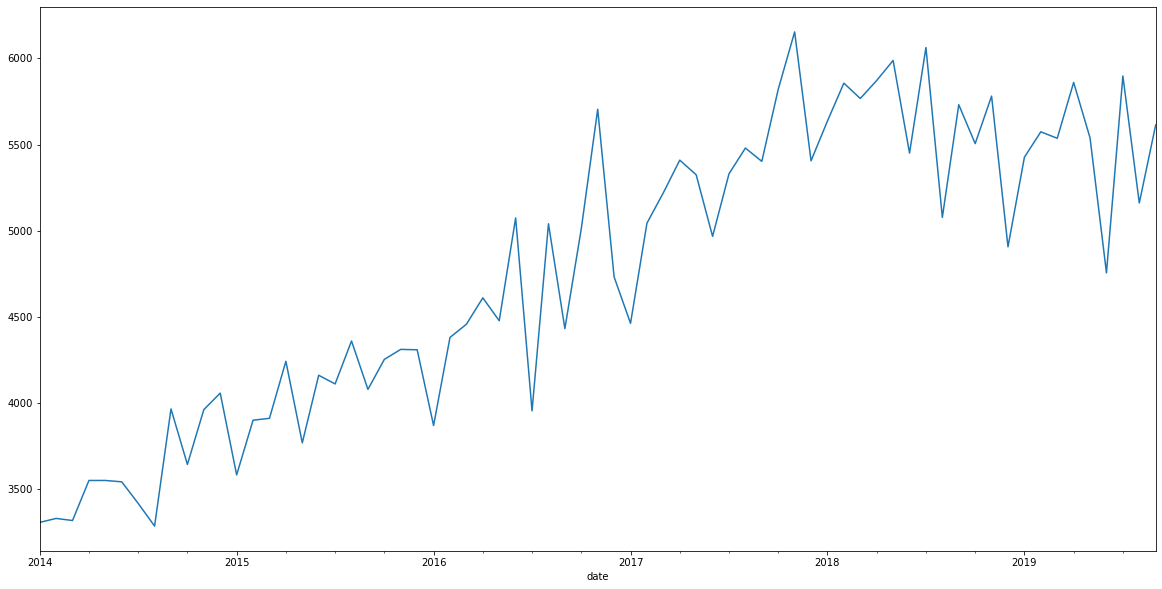

In [60]:
#Exploring the Data as TIME SERIES
#Step-01: Lets calculate the Total  Order Qty placed on by Each Day
df=df.groupby('date')["order_quantity"].sum().reset_index()
#Step-02: Indexing the Date Column as for further procssing.
df = df.set_index('date')
df.index #Lets check the index
#Step-03:#Averages daily sales value for the month, and we are using the start of each month as the timestamp.
monthly_avg_sales = df['order_quantity'].resample('MS').mean()
#In case there are Null values, they can be imputed using bfill.
monthly_avg_sales = monthly_avg_sales.fillna(monthly_avg_sales.bfill())
#Visualizing time series.

monthly_avg_sales.plot(figsize=(20,10))
plt.show()

#Findings: The sales are always low for the beginning of the year and the highest peak in demand every year is in the
#last quarter. The observed trend shows that orders were higher during 2014-2016 then reducing down slowly.


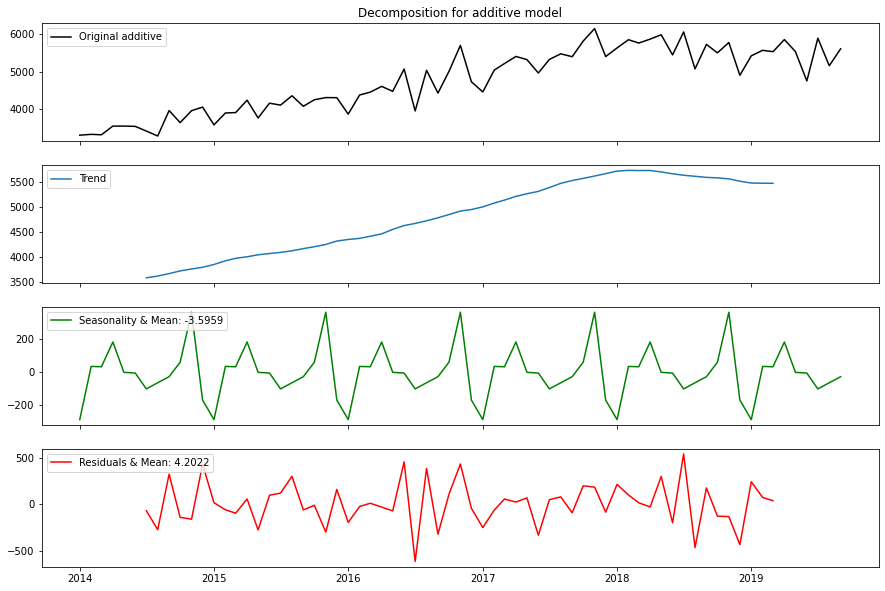

HO: Seri Durağan değildir.
H1: Seri Durağandır.
Sonuç: Seri Durağan Değildir (0.6158898940480205).


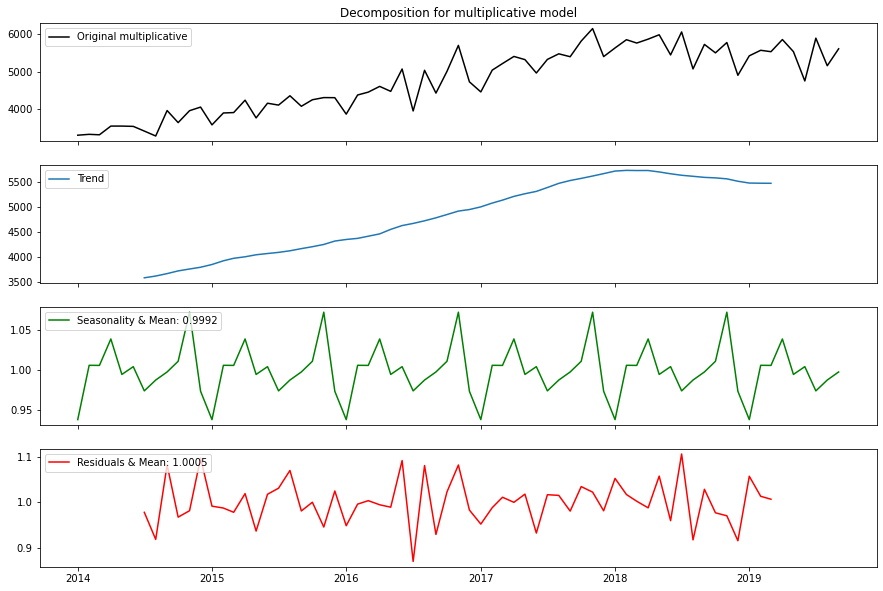

HO: Seri Durağan değildir.
H1: Seri Durağandır.
Sonuç: Seri Durağan Değildir (0.6158898940480205).


In [66]:

def ts_decompose(y, model="additive", stationary=False):
    from statsmodels.tsa.seasonal import seasonal_decompose
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show()

    if stationary:
        print("HO: Seri Durağan değildir.")
        print("H1: Seri Durağandır.")
        p_value = sm.tsa.stattools.adfuller(y)[1]
        if p_value < 0.05:
            print(F"Sonuç: Seri Durağandır ({p_value}).")
        else:
            print(F"Sonuç: Seri Durağan Değildir ({p_value}).")

for model in ["additive", "multiplicative"]:
    ts_decompose(monthly_avg_sales, model, True)


- TREND-LEVEL ve MEVSİMSELLİK açısında time series'i componentlerine ayırdığımızda:
    - Serinin durağan olmadığı
    - Multiplicative time series olduğu: Çünkü artıklar 0 -1 aralığında dağılıyor.
    - Yukarı yönlü bir artışın olduğu
    - Mevsimselliğin bulunduğu
    - Bu nedenle ARIMA modeline Seasonality yani mevsimsellik ekleyerek kullanacağız.Yani SARIMA: seasonal arıma

In [10]:

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Örnek parametreler  Seasonal ARIMA...')
print('SARIMAX1: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX2: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX3: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX4: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX1: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX2: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX3: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX4: (0, 1, 0) x (1, 0, 0, 12)


In [24]:
df.index

DatetimeIndex(['2014-01-02', '2014-01-02', '2014-01-02', '2014-01-03', '2014-01-03', '2014-01-04', '2014-01-06', '2014-01-06', '2014-01-08', '2014-01-08',
               ...
               '2019-07-12', '2019-07-17', '2019-07-18', '2019-07-22', '2019-07-25', '2019-07-26', '2019-07-27', '2019-08-07', '2019-08-08', '2019-08-29'], dtype='datetime64[ns]', name='date', length=7708479, freq=None)

In [25]:
weekly_avg_sales = df['order_quantity'].resample('W-Wed').mean()


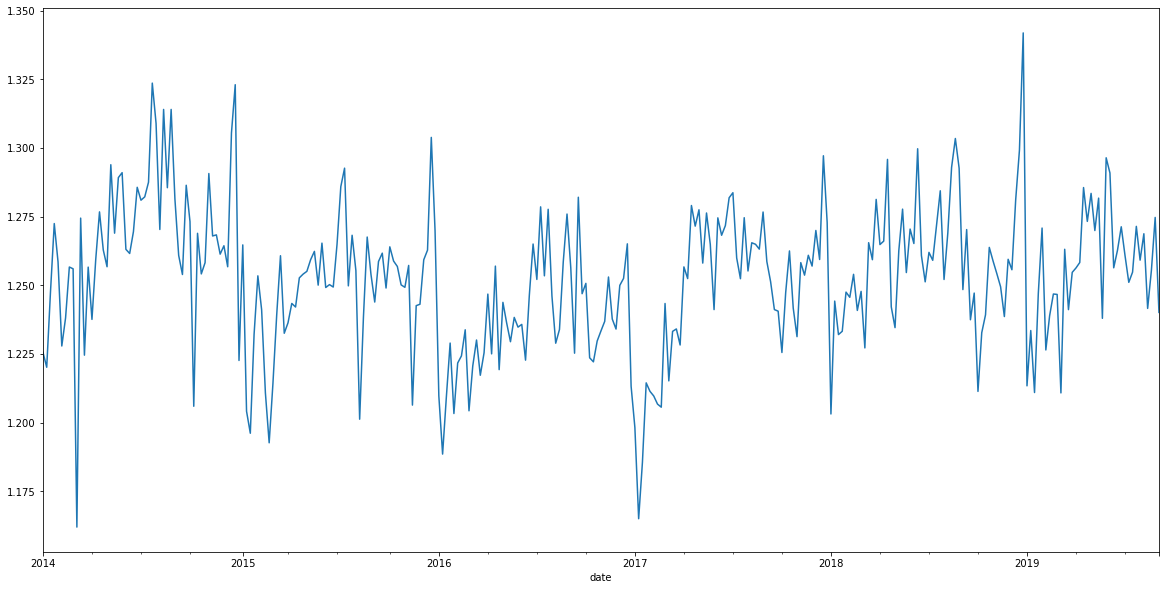

In [29]:

weekly_avg_sales.plot(figsize=(20,10))
plt.show()


#### Weekly forecasting istenildiği için Weekly olarka kuruyorum

In [26]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(weekly_avg_sales,
                                            order=param,
                                            seasonal_order=param_seasonal,enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:975.530618743261
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:595.1045505674429
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-1089.9816158775925
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-1175.8839561313941
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-1092.0876290055014
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-1213.3747376317028
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-1100.7756255889863


/Users/omergencayunlu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-1167.157312810984
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:576.1013492411463
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:223.47700346584818
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-1135.9576333239897
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-1229.8073947427151
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-1143.009749157294
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-1262.4790071413017
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-1167.66738123746
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-1224.831312242839
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-1306.089722979997
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-1282.5386899318846


/Users/omergencayunlu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-1084.131445511384
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-1189.2646667964486
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-1287.1406451824405
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-1280.6668573070958
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-1133.5167730220353
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-1189.7062266408057
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-1381.9985637495647
SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-1339.7990854352638
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-1136.0428118421203
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-1243.5331209697542
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-1350.3520632987002
SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-1337.8637454445102


/Users/omergencayunlu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-1178.7269412657674
SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-1243.0599361774412
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-1309.5047787501312
SARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-1285.546322548761
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-1169.0983474339528


/Users/omergencayunlu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-1264.0049176113703
SARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-1285.1889836476644
SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-1269.45753255596
SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-1198.1502700862027
SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-1261.5276334566652
SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-1384.3527125931698
SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-1342.5552846786684
SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-1168.6496133260953
SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-1267.7320632363362
SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-1348.3190472240888
SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-1330.2384909907591
SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-1188.477710703922
SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-1265.2532260056987
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-1354.7281794708279
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-1319.4111870856443
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-1124.2666763991167


/Users/omergencayunlu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-1225.9741090041798
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-1319.090419745188
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-1317.5696941723736
SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-1156.8226197665717


/Users/omergencayunlu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-1225.064054099887
SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-1386.7108562504695
SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-1349.656224260098
SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-1151.9326304359395
SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-1250.4040143771335
SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-1353.8380081199107
SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-1347.6728387528228
SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-1182.5174100930485
SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-1251.4854772993976


- p,d ve q değişkenleri için kombinasyonlara ve AIC skorlarına baktık.
- Ancak best skora bu şekilde ulaşmak zor olduğundan bir fonksiyon ile best kombinasyonu yakalamaya çalışalım

- Bu yapı SARIMAX modelini kurmakta,
- Itertools ile kombinasyon oluşturduğumuz p,d ve q değerleri üzeriden farklı modeller kurmakta
- Ardından AIC skoruna bakmakta
- AIC skorları arasından en iyi olanı belirleyip, p-d-q değerlini belirlememiz için yardımcı olmaktadır.
- Çıktı olarak da bunları ve AIC skorunu göstermektedir.
- Brute force yöntemi olarak belirtebilirim
- Best skor :SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-1386.7108562504695

In [40]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(weekly_avg_sales,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2484      0.071      3.488      0.000       0.109       0.388
ma.L1         -0.8263      0.052    -15.947      0.000      -0.928      -0.725
sigma2         0.0005   3.16e-05     16.182      0.000       0.000       0.001


#### Sonuçların Analizi: 
- coeff: değişkenlerin time series'i nasıl etkilediğine dair weight/importance değeridir
- Pvalu: Her bir feature ağırlığının önem düzeyini gösterir. Hipotez testi için kullanılır. Eğer p <.05 ise, istatistiki olarak anlamlıdır diyebiliriz.
- NULL hipotez, "Aralarında ilişki yoktur"
- p>.05 olur ise NULL hipotezi reddedilemez.
- Burada p<.05 çıktığı için, response ve predictor arasıda ilişki vardır diyebiliriz.

#### diagnostics görselleştirilmesi
- plot_diagnostics nesnesi, hızlı bir şekilde model tanılama oluşturmamıza ve olağandışı davranışları araştırmamıza olanak tanır.

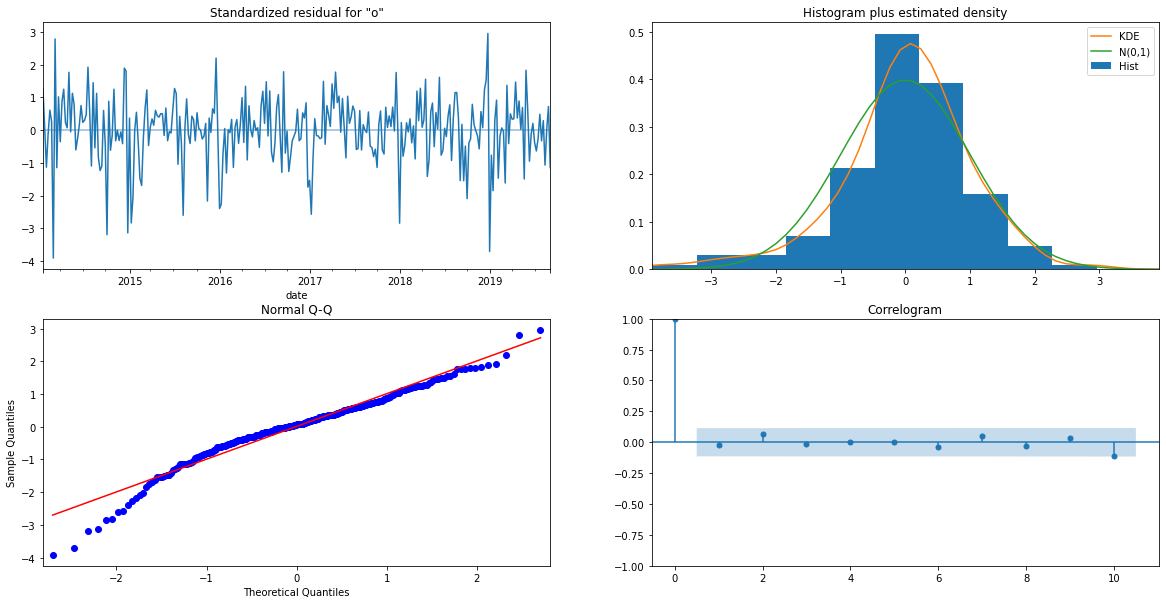

In [41]:
results.plot_diagnostics(figsize=(20, 10))
plt.show()

#### Yorumu:
-1. Artıklar Normal Olarak Dağıtılmalıdır ;

    - Sağ Üst: (turuncu renkli) KDE çizgisi, yeşil renkli N(0,1) çizgisiyle yakından eşleşmelidir. Bu, ortalama 0 ve sd 1 olan normal dağılım için standart gösterimdir.
    - Sol Alt: QQ grafiği, artıkların (mavi noktalar) sıralı dağılımını gösterir, N(0, 1) ile standart bir normal dağılımdan alınan örneklerin doğrusal eğilimini takip eder.
    
-2. Artıklar ilişkili değildir;

    - Sol Üst: Standart artıklar, belirgin bir mevsimsellik göstermez ve beyaz gürültü gibi görünür.
    - Sağ Alt: Sağ alttaki otokorelasyon (yani korelogram) grafiği, zaman serisi artıklarının
kendi gecikmeli sürümleriyle düşük korelasyon.

In [68]:
weekly_avg_sales.head()

date
2014-01-01    1.225609
2014-01-08    1.220146
2014-01-15    1.247614
2014-01-22    1.272485
2014-01-29    1.258533
Freq: W-WED, Name: order_quantity, dtype: float64

In [ ]:
# val= df.loc[(df["date"] >= "2018-09-04") & (df["date"] <= "2018-10-23"), :]

In [69]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)

In [70]:
pred_ci = pred.conf_int()


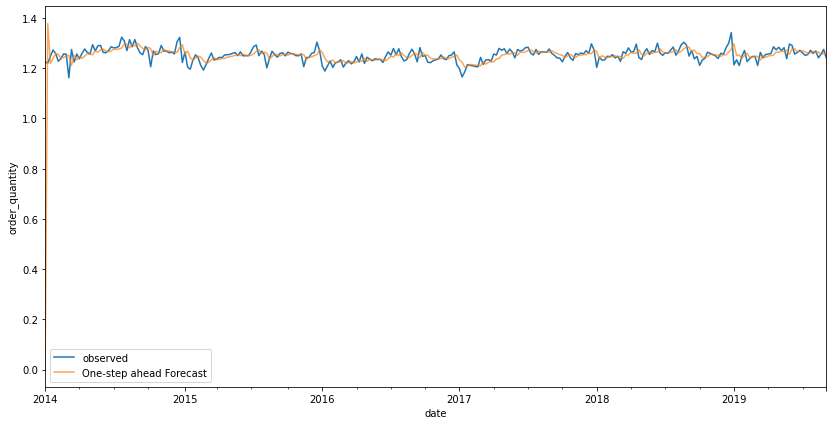

In [84]:
#Plotting real and forecasted values.
ax = weekly_avg_sales['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('order_quantity')
plt.legend()
plt.show()


- Bu grafiğie baktığımızda modelimizin bazı noktalarda real-data ile kesiştiği görülebilmektedir.
- Mevsimselllik ve TREND componentlerini belli noktalara yakalamış
- Modelin başarısını artırmak adına outlier değerleri de analiz ederek düzeltme yapılabilir

In [90]:


def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

In [96]:
y_forecasted = pred.predicted_mean
y_truth = weekly_avg_sales['2016':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('SMAPE {}'.format(smape(np.expm1(y_forecasted), np.expm1(y_truth))))
print('MSE {}'.format(round(mse, 2)))
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

SMAPE 1.4340882332269447
MSE 0.0
RMSE: 0.02


- Modelimizin validasyon setindeki başarısı LGBM ye göre çok daha yüksek. 
- SMAPE değeri 1.42 çıktı. LGBM de bu %35 civarıydı

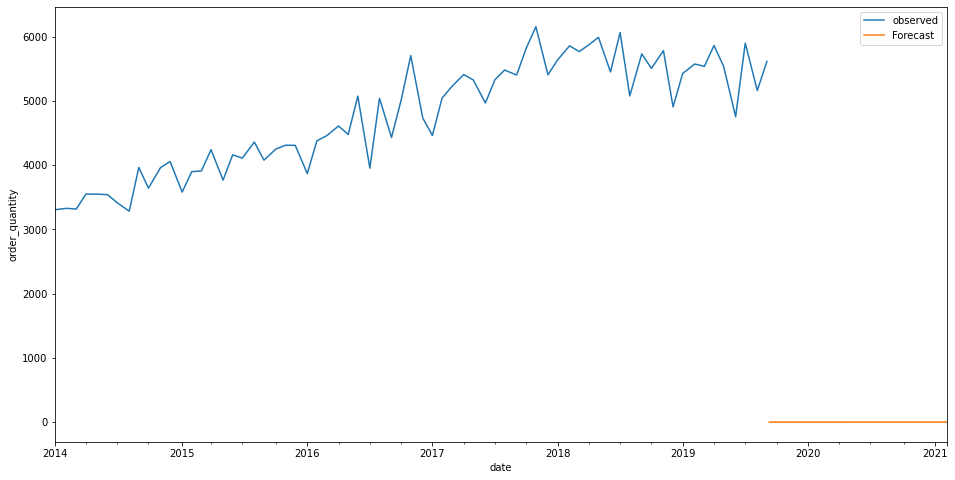

In [101]:
pred_uc = results.get_forecast(steps=75)
pred_ci = pred_uc.conf_int()
ax = monthly_avg_sales.plot(label='observed', figsize=(16, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('date')
ax.set_ylabel('order_quantity')
plt.legend()
plt.show()
